In [4]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D
import nibabel as nib
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow_io as tfio
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk


In [2]:
TF_ENABLE_ONEDNN_OPTS=0

In [ ]:
# data 2 set https://www.kaggle.com/competitions/rsna-intracranial-hemorrhage-detection/data

# Training

In [91]:
dict = './Lung_Train/'

# Function takes a list of folders, extract features from it, change the extractor inside function and the return dictionary
# to run exactly which feature, the key of the return dictionary can be found in mask.ipy and also listed in pyradiomics library
def LoadDataFromImages(foldernames):
    input_array = []
    output_array = []
    
    extractor = RadiomicsFeatureExtractor()
    # Disable all classes except firstorder
    extractor.disableAllFeatures()
    extractor.enableFeaturesByName(firstorder=['Variance'])  # change here to extract

    # glrlm HighGrayLevelRunEmphasis
    #radiomics_glcm_Contrast
    # ngtdm Strength
    
    # gldm_DependenceVariance
    for i in foldernames:
        files  = os.listdir(dict + i)
        for j in files:
            im = sitk.ReadImage(dict + i +'/' + j)
            
            # reshape and fill the input array
            input_array.append(sitk.GetArrayFromImage(im)[0].reshape(512,512,1))
            
            ma_arr = np.ones(im.GetSize()[::-1])  # reverse the order as image is xyz, array is zyx
            ma = sitk.GetImageFromArray(ma_arr)
            ma.CopyInformation(im)  # Copy geometric info
            
            # extract features and fill the output array
            features = extractor.execute(im, ma)
            
            output_array.append(features['original_firstorder_Variance'])  # change here to extract
            
    return input_array, output_array

In [12]:
# load the data from folders

input_array = []
output_array = []

input_array, output_array = LoadDataFromImages(['d1'
                                                ,'d2', 'd3', 'd4'
                                                ,'d5','d6','d7','d8','d9','d10','d11','d12'
                                                #,
                          #   'd2_1','d2_2', 'd2_3', 'd2_4','d2_5'
                                                ,'d2_6','d2_7','d2_8','d2_9','d2_10','d2_11','d2_12'
                             ,'d3_1','d3_2', 'd3_3', 'd3_4','d3_5','d3_6','d3_7','d3_8'
                           #  ,'d3_9','d3_10','d3_11','d3_12',
                          #                      "homo"
                              ])

In [13]:
# convert to np array
input_array = np.array(input_array)
output_array = np.array(output_array)

In [ ]:
# situation to prevent lost of data if out of memory
np.save("input_array.npy",input_array)
np.save("output_array.npy",output_array)

In [20]:
input_array = np.load("input_array.npy")
output_array = np.load("output_array.npy")

In [37]:
def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    x = Flatten()(input_layer)
    x = BatchNormalization(axis=1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)




    out = Dense(1, activation = 'linear', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [38]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)

In [39]:
model = MakeModel('Entropy')

In [40]:
model.summary()

Model: "Entropy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 flatten_2 (Flatten)         (None, 262144)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 262144)           1048576   
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 256)               67109120  
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 256)               65792     
                                                           

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0000001
), loss="mse")

In [52]:
model.fit(input_array, output_array, 
              epochs=500, 
          batch_size=64,
                shuffle=True
            )

Epoch 1/500
70/70 [==============================] - 2s 29ms/step - loss: 0.0689
Epoch 2/500
70/70 [==============================] - 2s 29ms/step - loss: 0.0797
Epoch 3/500
70/70 [==============================] - 2s 29ms/step - loss: 0.0870
Epoch 4/500
70/70 [==============================] - 2s 29ms/step - loss: 0.0791
Epoch 5/500
70/70 [==============================] - 2s 29ms/step - loss: 0.0723
Epoch 6/500
70/70 [==============================] - 2s 27ms/step - loss: 0.0739
Epoch 7/500
70/70 [==============================] - 2s 27ms/step - loss: 0.0715
Epoch 8/500
70/70 [==============================] - 2s 28ms/step - loss: 0.0674
Epoch 9/500
70/70 [==============================] - 2s 28ms/step - loss: 0.0749
Epoch 10/500
70/70 [==============================] - 2s 28ms/step - loss: 0.0673
Epoch 11/500
70/70 [==============================] - 2s 29ms/step - loss: 0.0676
Epoch 12/500
70/70 [==============================] - 2s 29ms/step - loss: 0.0632
Epoch 13/500
70/70 [=====

KeyboardInterrupt: 

Save, Load

In [54]:
model.save("./radiomics_Entropy2.h5")

In [94]:
model = load_model("./radiomics_Variance.h5")

# Testing

In [23]:
input_array_t = []
output_array_t = []

input_array_t, output_array_t = LoadDataFromImages([#'t1'
                                                   # ,
                                                  #  't2'
                                                   # ,
    't3'
    #,
    #'t4'
   #"homotest"
                                                   ])

In [95]:
input_array_t = np.array(input_array_t)
output_array_t = np.array(output_array_t)

5/5 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'FirstOrder Variance Prediction Graph')

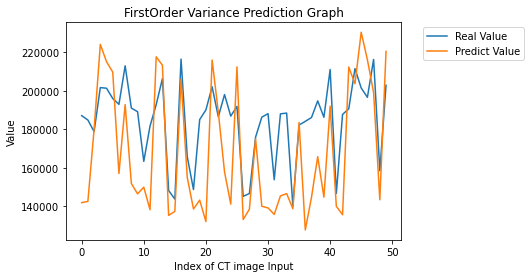

In [97]:

plt.plot(range(50),output_array_t[40:90] ,label='Real Value')
plt.plot(range(50),model.predict(input_array_t)[40:90]  ,label='Predict Value')
plt.xlabel("Index of CT image Input")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.title('FirstOrder Variance Prediction Graph')

#print(np.mean(test_array7, axis=1))

# Fine Tune

In [12]:
base_model =  load_model("radiomics_gldm_DependenceVariance.h5")

In [16]:
base_model.summary()

Model: "DependenceVariance"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 flatten_5 (Flatten)         (None, 262144)            0         
                                                                 
 batch_normalization_5 (Batc  (None, 262144)           1048576   
 hNormalization)                                                 
                                                                 
 dense_36 (Dense)            (None, 526)               137888270 
                                                                 
 dense_37 (Dense)            (None, 526)               277202    
                                                                 
 dense_38 (Dense)            (None, 526)               277202    
                                                

In [17]:
# how many layers for saving
newlayers = base_model.layers[7].output
n1 = Dense(526, activation='relu', name = 'dense_41')(newlayers)
out = Dense(1, activation='linear', name = 'DependenceVariance' )(n1)
new_model = keras.Model(base_model.input, outputs = out)

In [18]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 flatten_5 (Flatten)         (None, 262144)            0         
                                                                 
 batch_normalization_5 (Batc  (None, 262144)           1048576   
 hNormalization)                                                 
                                                                 
 dense_36 (Dense)            (None, 526)               137888270 
                                                                 
 dense_37 (Dense)            (None, 526)               277202    
                                                                 
 dense_38 (Dense)            (None, 526)               277202    
                                                           

In [20]:
for i in range(len(base_model.layers)): 
    keras.layers.trainable = True   # True--> fine tine, False-->frozen

In [22]:
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the new model: ", len(new_model.layers))

Number of layers in the base model:  10
Number of layers in the new model:  10


In [ ]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0000001
), loss="mse")

In [ ]:
new_model.fit(input_array, output_array, 
              epochs=500, 
          batch_size=64,
                shuffle=True
            )